In [3]:
import pandas as pd

df = pd.read_csv("PremierLeagueMatches.csv")

df.head()  # Muestra las primeras filas

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Matchday           1140 non-null   int64  
 1   Date               1140 non-null   object 
 2   Time               1140 non-null   object 
 3   Home Team          1140 non-null   object 
 4   homeScore          1049 non-null   float64
 5   homeXG             1049 non-null   float64
 6   awayScore          1049 non-null   float64
 7   awayXG             1049 non-null   float64
 8   Away Team          1140 non-null   object 
 9   Attendance         1045 non-null   object 
 10  Referee            1049 non-null   object 
 11  Stadium            1140 non-null   object 
 12  Result             1049 non-null   object 
 13  *Additional Stats  1049 non-null   object 
dtypes: float64(4), int64(1), object(9)
memory usage: 124.8+ KB


Paso 1: Conversión de tipos y limpieza inicial

In [5]:
# Copiamos el DataFrame original por seguridad
df_clean = df.copy()

# Convertir 'Date' a tipo datetime
df_clean['Date'] = pd.to_datetime(df_clean['Date'], errors='coerce')

# Limpiar 'Attendance' (quitar comas y convertir a float)
df_clean['Attendance'] = (
    df_clean['Attendance']
    .str.replace(',', '', regex=False)
    .astype(float)
)

# Renombrar columnas para quitar caracteres especiales y estandarizar
df_clean.rename(columns={
    'Home Team': 'home_team',
    'Away Team': 'away_team',
    'homeScore': 'home_score',
    'awayScore': 'away_score',
    'homeXG': 'home_xg',
    'awayXG': 'away_xg',
    'Matchday': 'matchday',
    'Date': 'date',
    'Time': 'time',
    'Attendance': 'attendance',
    'Referee': 'referee',
    'Stadium': 'stadium',
    'Result': 'result',
    '*Additional Stats': 'link'
}, inplace=True)

# Verificamos valores nulos en el DataFrame
df_clean.isnull().sum()


matchday       0
date           0
time           0
home_team      0
home_score    91
home_xg       91
away_score    91
away_xg       91
away_team      0
attendance    95
referee       91
stadium        0
result        91
link          91
dtype: int64

Interpretación de valores nulos
Columna	Valores nulos	Interpretación
home_score, away_score, home_xg, away_xg, result, referee, link	91	Corresponden casi seguro a partidos futuros aún no jugados
attendance	95	También podría incluir partidos futuros o juegos sin público/asistencia no registrada

 Recomendación
Dividamos el dataset en:

df_played — Partidos ya jugados (con home_score no nulo)

df_future — Partidos futuros (con home_score nulo)

Esto es útil para:

Visualizar el pasado

Crear modelos predictivos con datos ya jugados

Reservar los futuros para evaluar predicciones

In [7]:
# Partidos ya jugados
df_played = df_clean[df_clean['home_score'].notna()].copy()

# Partidos futuros
df_future = df_clean[df_clean['home_score'].isna()].copy()

# Tamaño de cada grupo
print("Partidos jugados:", len(df_played))
print("Partidos futuros:", len(df_future))


Partidos jugados: 1049
Partidos futuros: 91


Objetivo:
Mostrar qué equipos tienen el mejor promedio de goles anotados:

🔵 En casa (home_score)

🔴 Como visitante (away_score)

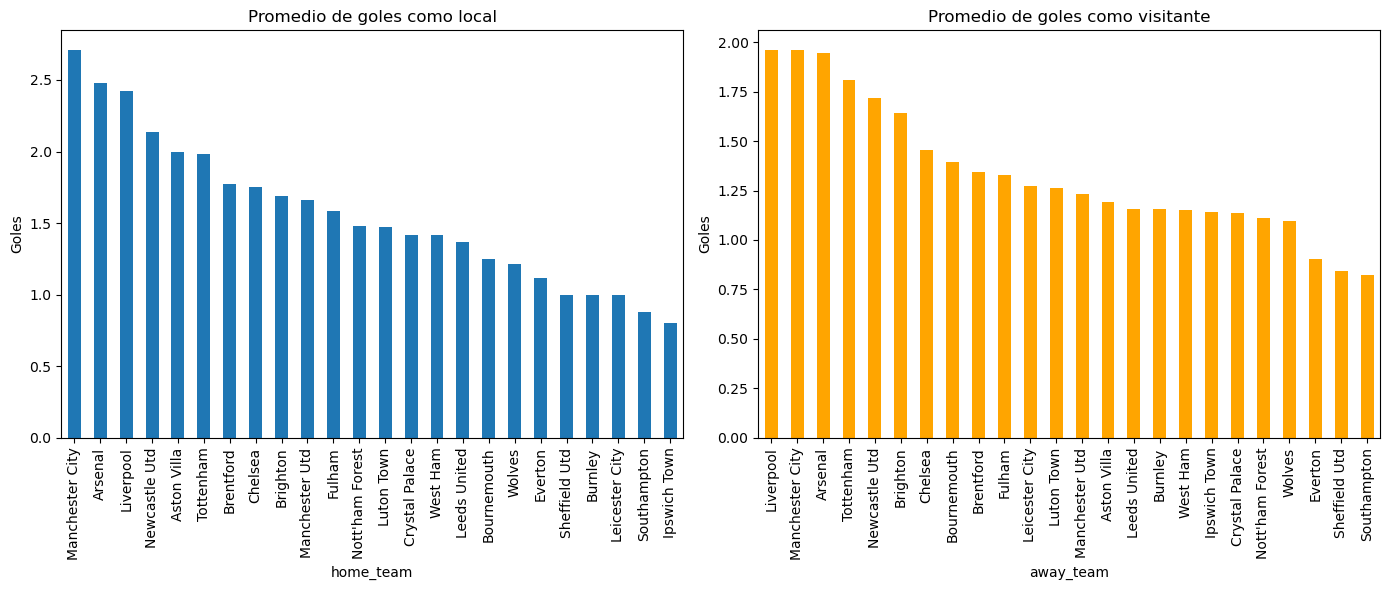

In [9]:
import matplotlib.pyplot as plt

# --- Promedio de goles como local ---
home_avg = (
    df_played.groupby('home_team')['home_score']
    .mean()
    .sort_values(ascending=False)
)

# --- Promedio de goles como visitante ---
away_avg = (
    df_played.groupby('away_team')['away_score']
    .mean()
    .sort_values(ascending=False)
)

# --- Visualización ---
plt.figure(figsize=(14, 6))

# Subplot 1: Goles en casa
plt.subplot(1, 2, 1)
home_avg.plot(kind='bar')
plt.title("Promedio de goles como local")
plt.ylabel("Goles")
plt.xticks(rotation=90)

# Subplot 2: Goles como visitante
plt.subplot(1, 2, 2)
away_avg.plot(kind='bar', color='orange')
plt.title("Promedio de goles como visitante")
plt.ylabel("Goles")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


Código paso a paso: Diferencia promedio entre goles y xG por equipo

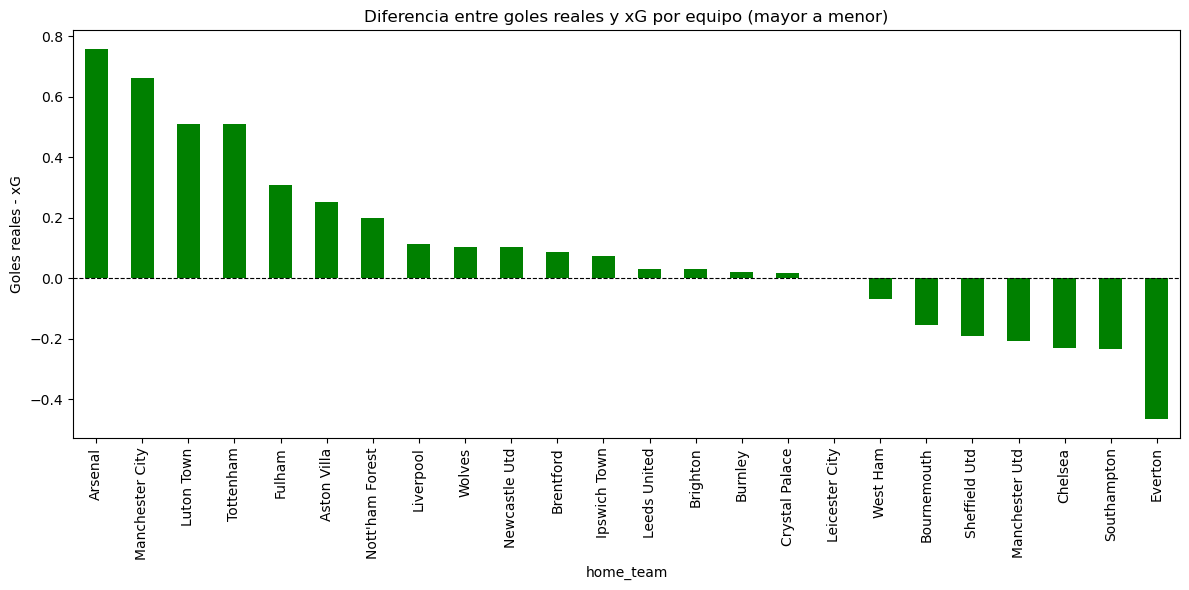

In [11]:
# --- Goles reales promedio como local y visitante ---
home_goals = df_played.groupby('home_team')['home_score'].mean()
away_goals = df_played.groupby('away_team')['away_score'].mean()

# --- xG promedio como local y visitante ---
home_xg = df_played.groupby('home_team')['home_xg'].mean()
away_xg = df_played.groupby('away_team')['away_xg'].mean()

# --- Goles totales y xG totales promedio por equipo ---
total_goals = home_goals.add(away_goals, fill_value=0)
total_xg = home_xg.add(away_xg, fill_value=0)

# --- Diferencia entre goles y xG (efectividad ofensiva) ---
goal_efficiency = (total_goals - total_xg).sort_values(ascending=False)

# --- Visualización ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
goal_efficiency.plot(kind='bar', color='green')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title("Diferencia entre goles reales y xG por equipo (mayor a menor)")
plt.ylabel("Goles reales - xG")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Interpretación rápida del gráfico:
🟢 Arsenal, Manchester City y Luton Town son los más eficientes: anotan más goles de los que indican sus xG, lo cual podría implicar:

Buen nivel de finalización

Jugadores letales

Efectividad por encima del promedio

🔴 Everton, Southampton y Chelsea están por debajo de su xG: generan oportunidades pero no las concretan. Esto puede sugerir:

Problemas de definición

Falta de suerte o decisiones de tiro inefectivas

 Código para comparar defensa real vs esperada (por equipo)

C:\Users\Rodrigo Lugo\AppData\Local\Temp\ipykernel_13500\3794787565.py:25: UserWarning: Glyph 128737 (\N{SHIELD}) missing from current font.
  plt.tight_layout()
C:\Users\Rodrigo Lugo\Documents\Mis formas\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128737 (\N{SHIELD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


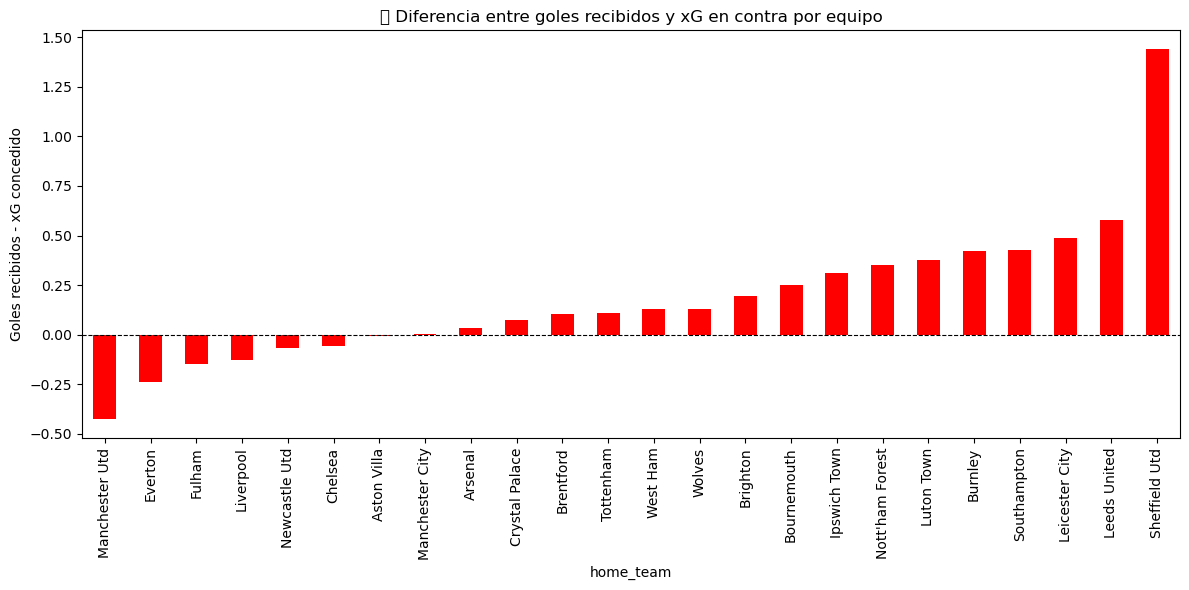

In [12]:
# --- Goles recibidos como local y visitante ---
home_goals_conceded = df_played.groupby('home_team')['away_score'].mean()
away_goals_conceded = df_played.groupby('away_team')['home_score'].mean()

# --- xG concedido como local y visitante ---
home_xg_conceded = df_played.groupby('home_team')['away_xg'].mean()
away_xg_conceded = df_played.groupby('away_team')['home_xg'].mean()

# --- Totales por equipo ---
total_goals_conceded = home_goals_conceded.add(away_goals_conceded, fill_value=0)
total_xg_conceded = home_xg_conceded.add(away_xg_conceded, fill_value=0)

# --- Diferencia: goles recibidos - xG concedido ---
defensive_efficiency = (total_goals_conceded - total_xg_conceded).sort_values()

# --- Visualización ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
defensive_efficiency.plot(kind='bar', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("🛡️ Diferencia entre goles recibidos y xG en contra por equipo")
plt.ylabel("Goles recibidos - xG concedido")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Interpretación:
🛡️ Manchester United y Everton: reciben menos goles de los esperados → probablemente tienen buenos porteros, defensas o bloqueos efectivos.

🚨 Sheffield United, Leeds United y Leicester City: reciben muchos más goles de lo que deberían → señales de una defensa débil o mala suerte recurrente.



In [14]:
# --- Eficiencia ofensiva ---
off_eff = (total_goals - total_xg).rename("ofensiva")

# --- Eficiencia defensiva ---
def_eff = (total_goals_conceded - total_xg_conceded).rename("defensiva")

# --- Combinar ambas métricas ---
summary = pd.concat([off_eff, def_eff], axis=1)

# --- Calcular balance total (ofensiva - defensiva) ---
summary["balance_total"] = summary["ofensiva"] - summary["defensiva"]

# --- Ordenar por balance total descendente ---
summary_sorted = summary.sort_values(by="balance_total", ascending=False)


# Mostrar las primeras filas del resumen
print(summary_sorted.head(10))  # O puedes usar display() si estás en Jupyter



                 ofensiva  defensiva  balance_total
home_team                                          
Arsenal          0.758128   0.032075       0.726052
Manchester City  0.661829   0.000871       0.660958
Fulham           0.306967  -0.146190       0.453157
Tottenham        0.510486   0.107293       0.403193
Aston Villa      0.251524  -0.008454       0.259978
Liverpool        0.111393  -0.126016       0.237409
Manchester Utd  -0.208672  -0.426814       0.218142
Newcastle Utd    0.102775  -0.069293       0.172068
Luton Town       0.510526   0.378947       0.131579
Brentford        0.087083   0.105842      -0.018759


Código para visualización de eficiencia combinada

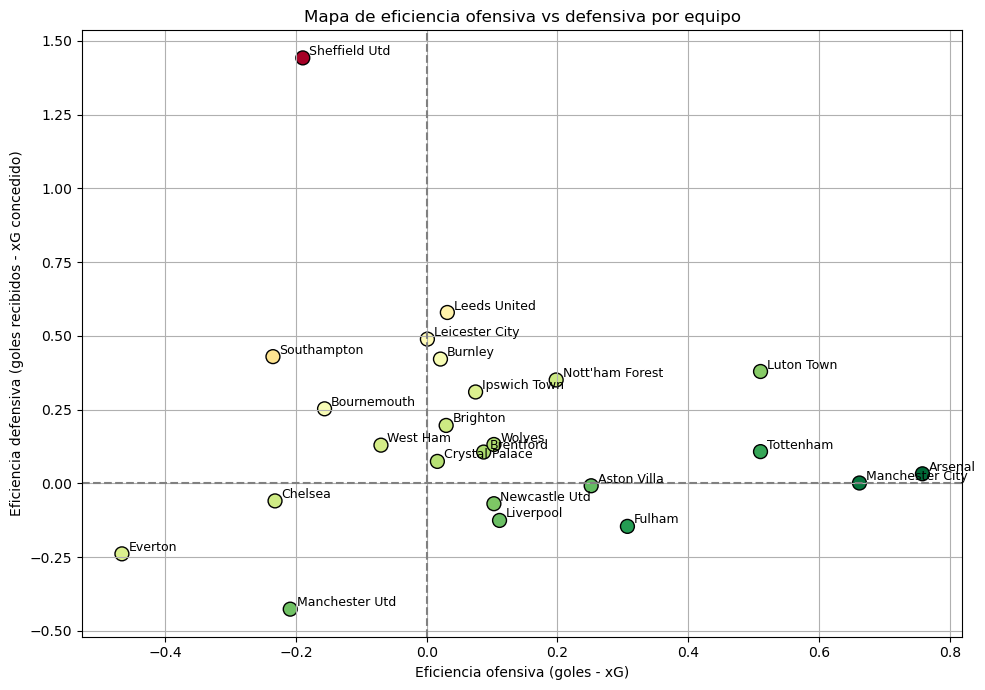

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(summary_sorted["ofensiva"], summary_sorted["defensiva"], 
            c=summary_sorted["balance_total"], cmap='RdYlGn', s=100, edgecolor='black')

# Etiquetar cada punto con el nombre del equipo
for team, row in summary_sorted.iterrows():
    plt.text(row["ofensiva"] + 0.01, row["defensiva"] + 0.01, team, fontsize=9)

plt.axvline(0, color='grey', linestyle='--')  # Línea vertical en x = 0
plt.axhline(0, color='grey', linestyle='--')  # Línea horizontal en y = 0

plt.title("Mapa de eficiencia ofensiva vs defensiva por equipo")
plt.xlabel("Eficiencia ofensiva (goles - xG)")
plt.ylabel("Eficiencia defensiva (goles recibidos - xG concedido)")
plt.grid(True)
plt.tight_layout()
plt.show()


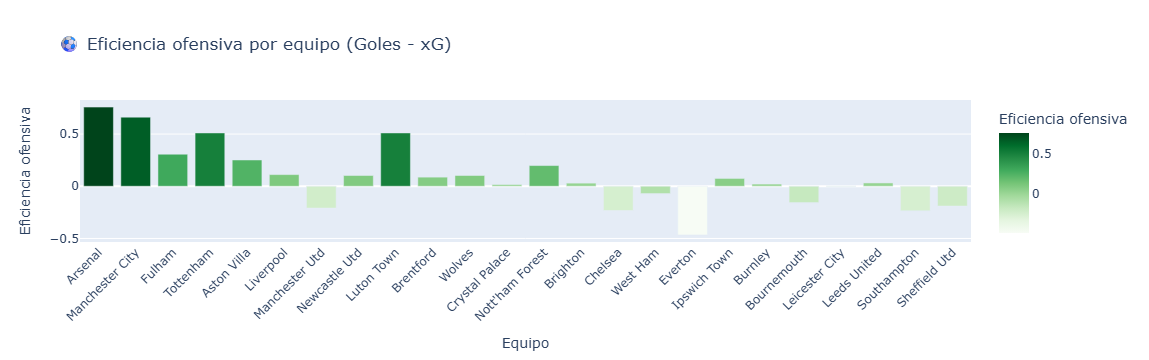

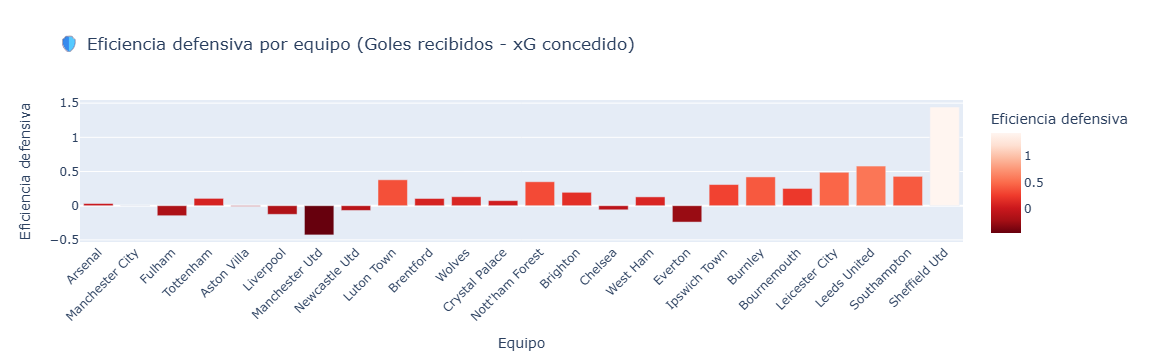

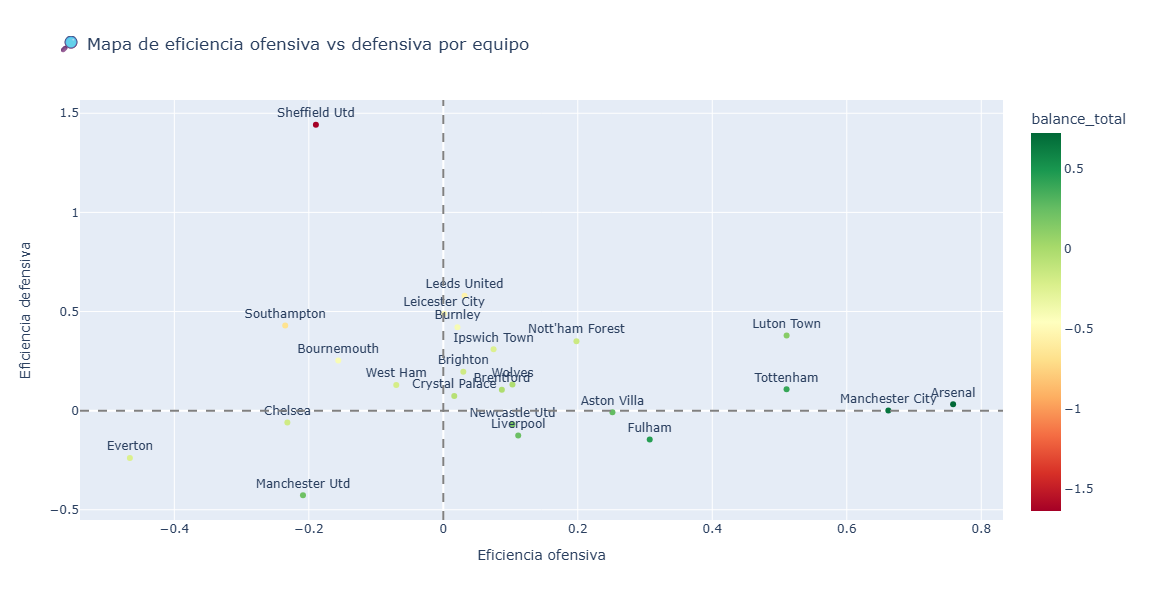

In [18]:
import plotly.express as px
import plotly.graph_objects as go

# --- 1. Eficiencia ofensiva (barplot) ---
fig_ofensiva = px.bar(
    summary_sorted.reset_index(), 
    x='home_team', y='ofensiva',
    title='⚽ Eficiencia ofensiva por equipo (Goles - xG)',
    labels={'home_team': 'Equipo', 'ofensiva': 'Eficiencia ofensiva'},
    color='ofensiva', 
    color_continuous_scale='Greens'
)
fig_ofensiva.update_layout(xaxis_tickangle=-45)
fig_ofensiva.show()

# --- 2. Eficiencia defensiva (barplot) ---
fig_defensiva = px.bar(
    summary_sorted.reset_index(), 
    x='home_team', y='defensiva',
    title='🛡️ Eficiencia defensiva por equipo (Goles recibidos - xG concedido)',
    labels={'home_team': 'Equipo', 'defensiva': 'Eficiencia defensiva'},
    color='defensiva',
    color_continuous_scale='Reds_r'
)
fig_defensiva.update_layout(xaxis_tickangle=-45)
fig_defensiva.show()

# --- 3. Mapa de eficiencia combinada (scatter plot) ---
fig_balance = px.scatter(
    summary_sorted.reset_index(),
    x='ofensiva', y='defensiva',
    text='home_team',
    color='balance_total',
    color_continuous_scale='RdYlGn',
    title='🔎 Mapa de eficiencia ofensiva vs defensiva por equipo',
    labels={'ofensiva': 'Eficiencia ofensiva', 'defensiva': 'Eficiencia defensiva'}
)

fig_balance.update_traces(textposition='top center')
fig_balance.add_hline(y=0, line_dash="dash", line_color="gray")
fig_balance.add_vline(x=0, line_dash="dash", line_color="gray")
fig_balance.update_layout(height=600)
fig_balance.show()


In [19]:
df = pd.read_csv("PremierLeagueMatches.csv")


In [21]:
print(df.head())


   Matchday        Date   Time       Home Team  homeScore  homeXG  awayScore  \
0         1  2022-08-05  20:00  Crystal Palace        0.0     1.2        2.0   
1         1  2022-08-06  12:30          Fulham        2.0     1.2        2.0   
2         1  2022-08-06  15:00       Tottenham        4.0     1.5        1.0   
3         1  2022-08-06  15:00   Newcastle Utd        2.0     1.7        0.0   
4         1  2022-08-06  15:00    Leeds United        2.0     0.8        1.0   

   awayXG        Away Team Attendance         Referee  \
0     1.0          Arsenal     25,286  Anthony Taylor   
1     1.2        Liverpool     22,207     Andy Madley   
2     0.5      Southampton     61,732  Andre Marriner   
3     0.3  Nott'ham Forest     52,245    Simon Hooper   
4     1.3           Wolves     36,347    Robert Jones   

                     Stadium Result  \
0              Selhurst Park      A   
1             Craven Cottage      D   
2  Tottenham Hotspur Stadium      H   
3             St Jam